In [81]:
import pandas as pd
import numpy as np
import os

from enum import Enum

DATA_DIR = './Data/'

# stock_id_num = 126

In [87]:
class DataBlock(Enum):
    TRAIN = 1
    TEST = 2
    BOTH = 3

def load_stock_data(stock_id: int, directory: str) -> pd.DataFrame:
    return pd.read_parquet(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', directory, f'stock_id={stock_id}'))


def load_data(stock_id: int, stem: str, block: DataBlock) -> pd.DataFrame:
    if block == DataBlock.TRAIN:
        return load_stock_data(stock_id, f'{stem}_train.parquet')
    elif block == DataBlock.TEST:
        return load_stock_data(stock_id, f'{stem}_test.parquet')
    else:
        return pd.concat([
            load_data(stock_id, stem, DataBlock.TRAIN),
            load_data(stock_id, stem, DataBlock.TEST)
        ]).reset_index(drop=True)

def load_book(stock_id: int, block: DataBlock=DataBlock.TRAIN) -> pd.DataFrame:
    return load_data(stock_id, 'book', block)


def load_trade(stock_id: int, block=DataBlock.TRAIN) -> pd.DataFrame:
    return load_data(stock_id, 'trade', block)


def calc_wap1(df: pd.DataFrame) -> pd.Series:
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap


def calc_wap2(df: pd.DataFrame) -> pd.Series:
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap


def realized_volatility(series):
    return np.sqrt(np.sum(series**2))


def log_return(series: np.ndarray):
    return np.log(series).diff()


def log_return_df2(series: np.ndarray):
    return np.log(series).diff(2)


def flatten_name(prefix, src_names):
    ret = []
    for c in src_names:
        if c[0] in ['time_id', 'stock_id']:
            ret.append(c[0])
        else:
            ret.append('.'.join([prefix] + list(c)))
    return ret


def make_book_feature(stock_id, block = DataBlock.TRAIN):
    book = load_book(stock_id, block)

    book['wap1'] = calc_wap1(book)
    book['wap2'] = calc_wap2(book)
    book['log_return1'] = book.groupby(['time_id'])['wap1'].apply(log_return)
    book['log_return2'] = book.groupby(['time_id'])['wap2'].apply(log_return)
    book['log_return_ask1'] = book.groupby(['time_id'])['ask_price1'].apply(log_return)
    book['log_return_ask2'] = book.groupby(['time_id'])['ask_price2'].apply(log_return)
    book['log_return_bid1'] = book.groupby(['time_id'])['bid_price1'].apply(log_return)
    book['log_return_bid2'] = book.groupby(['time_id'])['bid_price2'].apply(log_return)

    book['wap_balance'] = abs(book['wap1'] - book['wap2'])
    book['price_spread'] = (book['ask_price1'] - book['bid_price1']) / ((book['ask_price1'] + book['bid_price1']) / 2)
    book['bid_spread'] = book['bid_price1'] - book['bid_price2']
    book['ask_spread'] = book['ask_price1'] - book['ask_price2']
    book['total_volume'] = (book['ask_size1'] + book['ask_size2']) + (book['bid_size1'] + book['bid_size2'])
    book['volume_imbalance'] = abs((book['ask_size1'] + book['ask_size2']) - (book['bid_size1'] + book['bid_size2']))
    
    features = {
        'seconds_in_bucket': ['count'],
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid2': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std]
    }
    
    agg = book.groupby('time_id').agg(features).reset_index(drop=False)
    agg.columns = flatten_name('book', agg.columns)
    agg['stock_id'] = stock_id
    
    for time in [450, 300, 150]:
        d = book[book['seconds_in_bucket'] >= time].groupby('time_id').agg(features).reset_index(drop=False)
        d.columns = flatten_name(f'book_{time}', d.columns)
        agg = pd.merge(agg, d, on='time_id', how='left')
    return agg


In [102]:
stock_id_list = os.listdir(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction/book_train.parquet'))
stock_id_list = [int(x[9:]) for x in stock_id_list]

# for idx in stock_id_list:
#     print(load_stock_data(idx, 'book_train.parquet').iloc[0])

tmp = load_stock_data(0, 'book_train.parquet')
tmp

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100
...,...,...,...,...,...,...,...,...,...,...
917548,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28
917549,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28
917550,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28
917551,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28


In [111]:
make_book_feature(0, 'trade')

,time_id,book.seconds_in_bucket.count,book.wap1.sum,book.wap1.mean,book.wap1.std,book.wap2.sum,book.wap2.mean,book.wap2.std,book.log_return1.sum,book.log_return1.realized_volatility,...,book_150.bid_spread.std,book_150.ask_spread.sum,book_150.ask_spread.mean,book_150.ask_spread.std,book_150.total_volume.sum,book_150.total_volume.mean,book_150.total_volume.std,book_150.volume_imbalance.sum,book_150.volume_imbalance.mean,book_150.volume_imbalance.std
0,4,3,3.001215,1.000405,0.000170,3.001650,1.000550,0.000153,0.000294,0.000294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,302,303.125061,1.003725,0.000693,303.105539,1.003661,0.000781,0.002292,0.004499,...,0.000165,-0.034024,-0.000147,0.000120,75964.0,327.431034,142.761068,28672.0,123.586207,103.533216
2,11,200,200.047768,1.000239,0.000262,200.041171,1.000206,0.000272,0.000360,0.001204,...,0.000154,-0.022032,-0.000127,0.000058,72535.0,419.277457,178.652395,26221.0,151.566474,104.576846
3,16,188,187.913849,0.999542,0.000864,187.939824,0.999680,0.000862,-0.002074,0.002369,...,0.000155,-0.028626,-0.000241,0.000195,50996.0,428.537815,135.376048,15718.0,132.084034,114.924631
4,31,120,119.859781,0.998832,0.000757,119.835941,0.998633,0.000656,-0.002828,0.002574,...,0.000191,-0.008745,-0.000108,0.000085,34363.0,424.234568,156.628404,12293.0,151.765432,124.293028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3826,32751,297,296.387479,0.997938,0.000747,296.365481,0.997864,0.000769,-0.002136,0.002579,...,0.000030,-0.038915,-0.000171,0.000118,79431.0,349.916300,168.444647,44575.0,196.365639,137.189564
3827,32753,206,206.063903,1.000310,0.000551,206.100395,1.000487,0.000599,0.000403,0.002206,...,0.000073,-0.026583,-0.000181,0.000085,104044.0,707.782313,248.050412,37316.0,253.850340,159.936518
3828,32758,188,187.915689,0.999552,0.000743,187.897700,0.999456,0.000736,0.001663,0.002913,...,0.000150,-0.011187,-0.000084,0.000066,41648.0,313.142857,129.148560,13702.0,103.022556,84.414783
3829,32763,307,307.723687,1.002357,0.000356,307.732623,1.002386,0.000424,0.000520,0.003046,...,0.000070,-0.032307,-0.000148,0.000145,85251.0,389.273973,146.309737,26493.0,120.972603,90.168594


In [107]:
pd.read_csv('./Data/optiver-realized-volatility-prediction/test.csv')

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [118]:
load_stock_data(4, 'trade_test.parquet')

FileNotFoundError: [Errno 2] No such file or directory: './Data/optiver-realized-volatility-prediction/trade_test.parquet/stock_id=4'

In [73]:
train_y = pd.read_csv('./Data/optiver-realized-volatility-prediction/train.csv')

In [74]:
train_y[train_y.stock_id == 0]

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
3825,0,32751,0.002611
3826,0,32753,0.001190
3827,0,32758,0.004264
3828,0,32763,0.004352


In [77]:
train_df = pd.read_parquet('./Data/optiver-realized-volatility-prediction/book_train.parquet')
train_df[train_df.columns[0:1]] = train_df[train_df.columns[0:1]].astype(int)
train_df[train_df.columns[6:]] = train_df[train_df.columns[6:]].astype(int)

In [78]:
train_df.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0


In [ ]:
train_df['wap'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])

In [70]:
stock_id_list = train_df.stock_id.unique()
stock_id_list

array([  0,   1,  10, 100, 101, 102, 103, 104, 105, 107, 108, 109,  11,
       110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124,
       125, 126,  13,  14,  15,  16,  17,  18,  19,   2,  20,  21,  22,
        23,  26,  27,  28,  29,   3,  30,  31,  32,  33,  34,  35,  36,
        37,  38,  39,   4,  40,  41,  42,  43,  44,  46,  47,  48,   5,
        50,  51,  52,  53,  55,  56,  58,  59,   6,  60,  61,  62,  63,
        64,  66,  67,  68,  69,   7,  70,  72,  73,  74,  75,  76,  77,
        78,   8,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,   9,
        90,  93,  94,  95,  96,  97,  98,  99])

In [72]:
train_df[train_df.stock_id == 0].time_id.unique()

array([    5,    11,    16, ..., 32758, 32763, 32767])

In [ ]:
train_df[train_df.stock_id == 0].seconds.unique()

In [ ]:
def individual_stock_spliting (train_df, stock_id):

    time_id_list = train_df[train_df.stock_id == 0].time_id.unique()

        

    return train_df[train_df ]

In [54]:
from joblib import delayed, Parallel

    Parallel(n_jobs=-1)(delayed(make_book_feature)(i, block) for i in stock_ids_list)

ModuleNotFoundError: No module named 'parallels'

In [11]:
train_df.stock_id.unique()

array([  0,   1,  10, 100, 101, 102, 103, 104, 105, 107, 108, 109,  11,
       110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124,
       125, 126,  13,  14,  15,  16,  17,  18,  19,   2,  20,  21,  22,
        23,  26,  27,  28,  29,   3,  30,  31,  32,  33,  34,  35,  36,
        37,  38,  39,   4,  40,  41,  42,  43,  44,  46,  47,  48,   5,
        50,  51,  52,  53,  55,  56,  58,  59,   6,  60,  61,  62,  63,
        64,  66,  67,  68,  69,   7,  70,  72,  73,  74,  75,  76,  77,
        78,   8,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,   9,
        90,  93,  94,  95,  96,  97,  98,  99])

In [12]:
stock_0 = train_df[train_df.stock_id == 0]
stock_0.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0


bucket = 10분단위 <br>
time_id = 

In [13]:
np.linspace(0, 60, 61)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60.])

In [14]:
train_df[(train_df.stock_id == 0)].time_id

0             5
1             5
2             5
3             5
4             5
          ...  
917548    32767
917549    32767
917550    32767
917551    32767
917552    32767
Name: time_id, Length: 917553, dtype: int16

In [15]:
k = train_df[(train_df.stock_id == 0) & (train_df.time_id == 5)]
k

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
...,...,...,...,...,...,...,...,...,...,...,...
297,5,585,1.003129,1.003749,1.003025,1.003801,100,3,26,3,0
298,5,586,1.003129,1.003749,1.002612,1.003801,100,3,2,3,0
299,5,587,1.003129,1.003749,1.003025,1.003801,100,3,26,3,0
300,5,588,1.003129,1.003749,1.002612,1.003801,100,3,2,3,0


In [23]:
k['wap'] =(k['bid_price1'] * k['ask_size1']+k['ask_price1'] * k['bid_size1'])  / (
            k['bid_size1']+ k['ask_size1'])

/var/folders/0k/zyr795gx3hl6x1nytrrntcnc0000gn/T/ipykernel_40512/3289878375.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k['wap'] =(k['bid_price1'] * k['ask_size1']+k['ask_price1'] * k['bid_size1'])  / (


In [24]:
k['wap']

0      1.001434
1      1.001448
2      1.001448
3      1.001443
4      1.001443
         ...   
297    1.003731
298    1.003731
299    1.003731
300    1.003731
301    1.003731
Name: wap, Length: 302, dtype: float64

In [26]:
k

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,wap
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,0,1.001434
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,0,1.001448
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0,1.001448
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0,1.001443
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0,1.001443
...,...,...,...,...,...,...,...,...,...,...,...,...
297,5,585,1.003129,1.003749,1.003025,1.003801,100,3,26,3,0,1.003731
298,5,586,1.003129,1.003749,1.002612,1.003801,100,3,2,3,0,1.003731
299,5,587,1.003129,1.003749,1.003025,1.003801,100,3,26,3,0,1.003731
300,5,588,1.003129,1.003749,1.002612,1.003801,100,3,2,3,0,1.003731


In [48]:
k2 = train_df[(train_df.stock_id == 2) & (train_df.time_id == 5)]
k2
#k2['wap'] =(k2['bid_price1'] * k2['ask2_size1']+k2['ask2_price1'] * k2['bid_size1'])  / (
#            k2['bid_size1']+ k2['ask2_size1'])
#k2['wap']
k2

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
51904265,5,0,1.000607,1.000769,1.000526,1.000850,100,200,1,1,2
51904266,5,1,1.000526,1.000769,1.000445,1.000850,1,200,100,101,2
51904267,5,2,1.000526,1.000769,1.000364,1.000850,1,300,112,101,2
51904268,5,3,1.000607,1.000769,1.000526,1.000850,100,300,1,1,2
51904269,5,4,1.000526,1.000769,1.000445,1.000850,1,300,300,101,2
...,...,...,...,...,...,...,...,...,...,...,...
51904843,5,595,1.002308,1.002470,1.002227,1.002551,112,301,501,2,2
51904844,5,596,1.002308,1.002470,1.002227,1.002551,112,301,401,102,2
51904845,5,597,1.002308,1.002470,1.002227,1.002551,112,301,401,102,2
51904846,5,598,1.002308,1.002470,1.002227,1.002551,112,301,601,2,2


In [42]:
a = k.columns[2:10].to_list()
a.append('wap')
a

['bid_price1',
 'ask_price1',
 'bid_price2',
 'ask_price2',
 'bid_size1',
 'ask_size1',
 'bid_size2',
 'ask_size2',
 'wap']

In [43]:
import seaborn as sns

,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,wap
bid_price1,1.000000,0.937224,0.962200,0.952829,0.139910,0.031660,0.269373,-0.023443,0.890903
ask_price1,0.937224,1.000000,0.928800,0.978090,0.197137,0.154407,0.246499,0.080933,0.871634
bid_price2,0.962200,0.928800,1.000000,0.935175,0.149611,0.038609,0.245811,-0.032249,0.872605
ask_price2,0.952829,0.978090,0.935175,1.000000,0.184495,0.129296,0.248983,0.041180,0.873892
bid_size1,0.139910,0.197137,0.149611,0.184495,1.000000,-0.195881,-0.094538,-0.076770,0.450903
ask_size1,0.031660,0.154407,0.038609,0.129296,-0.195881,1.000000,-0.140147,0.237783,-0.228800
bid_size2,0.269373,0.246499,0.245811,0.248983,-0.094538,-0.140147,1.000000,-0.061228,0.244108
ask_size2,-0.023443,0.080933,-0.032249,0.041180,-0.076770,0.237783,-0.061228,1.000000,-0.080917
wap,0.890903,0.871634,0.872605,0.873892,0.450903,-0.228800,0.244108,-0.080917,1.000000


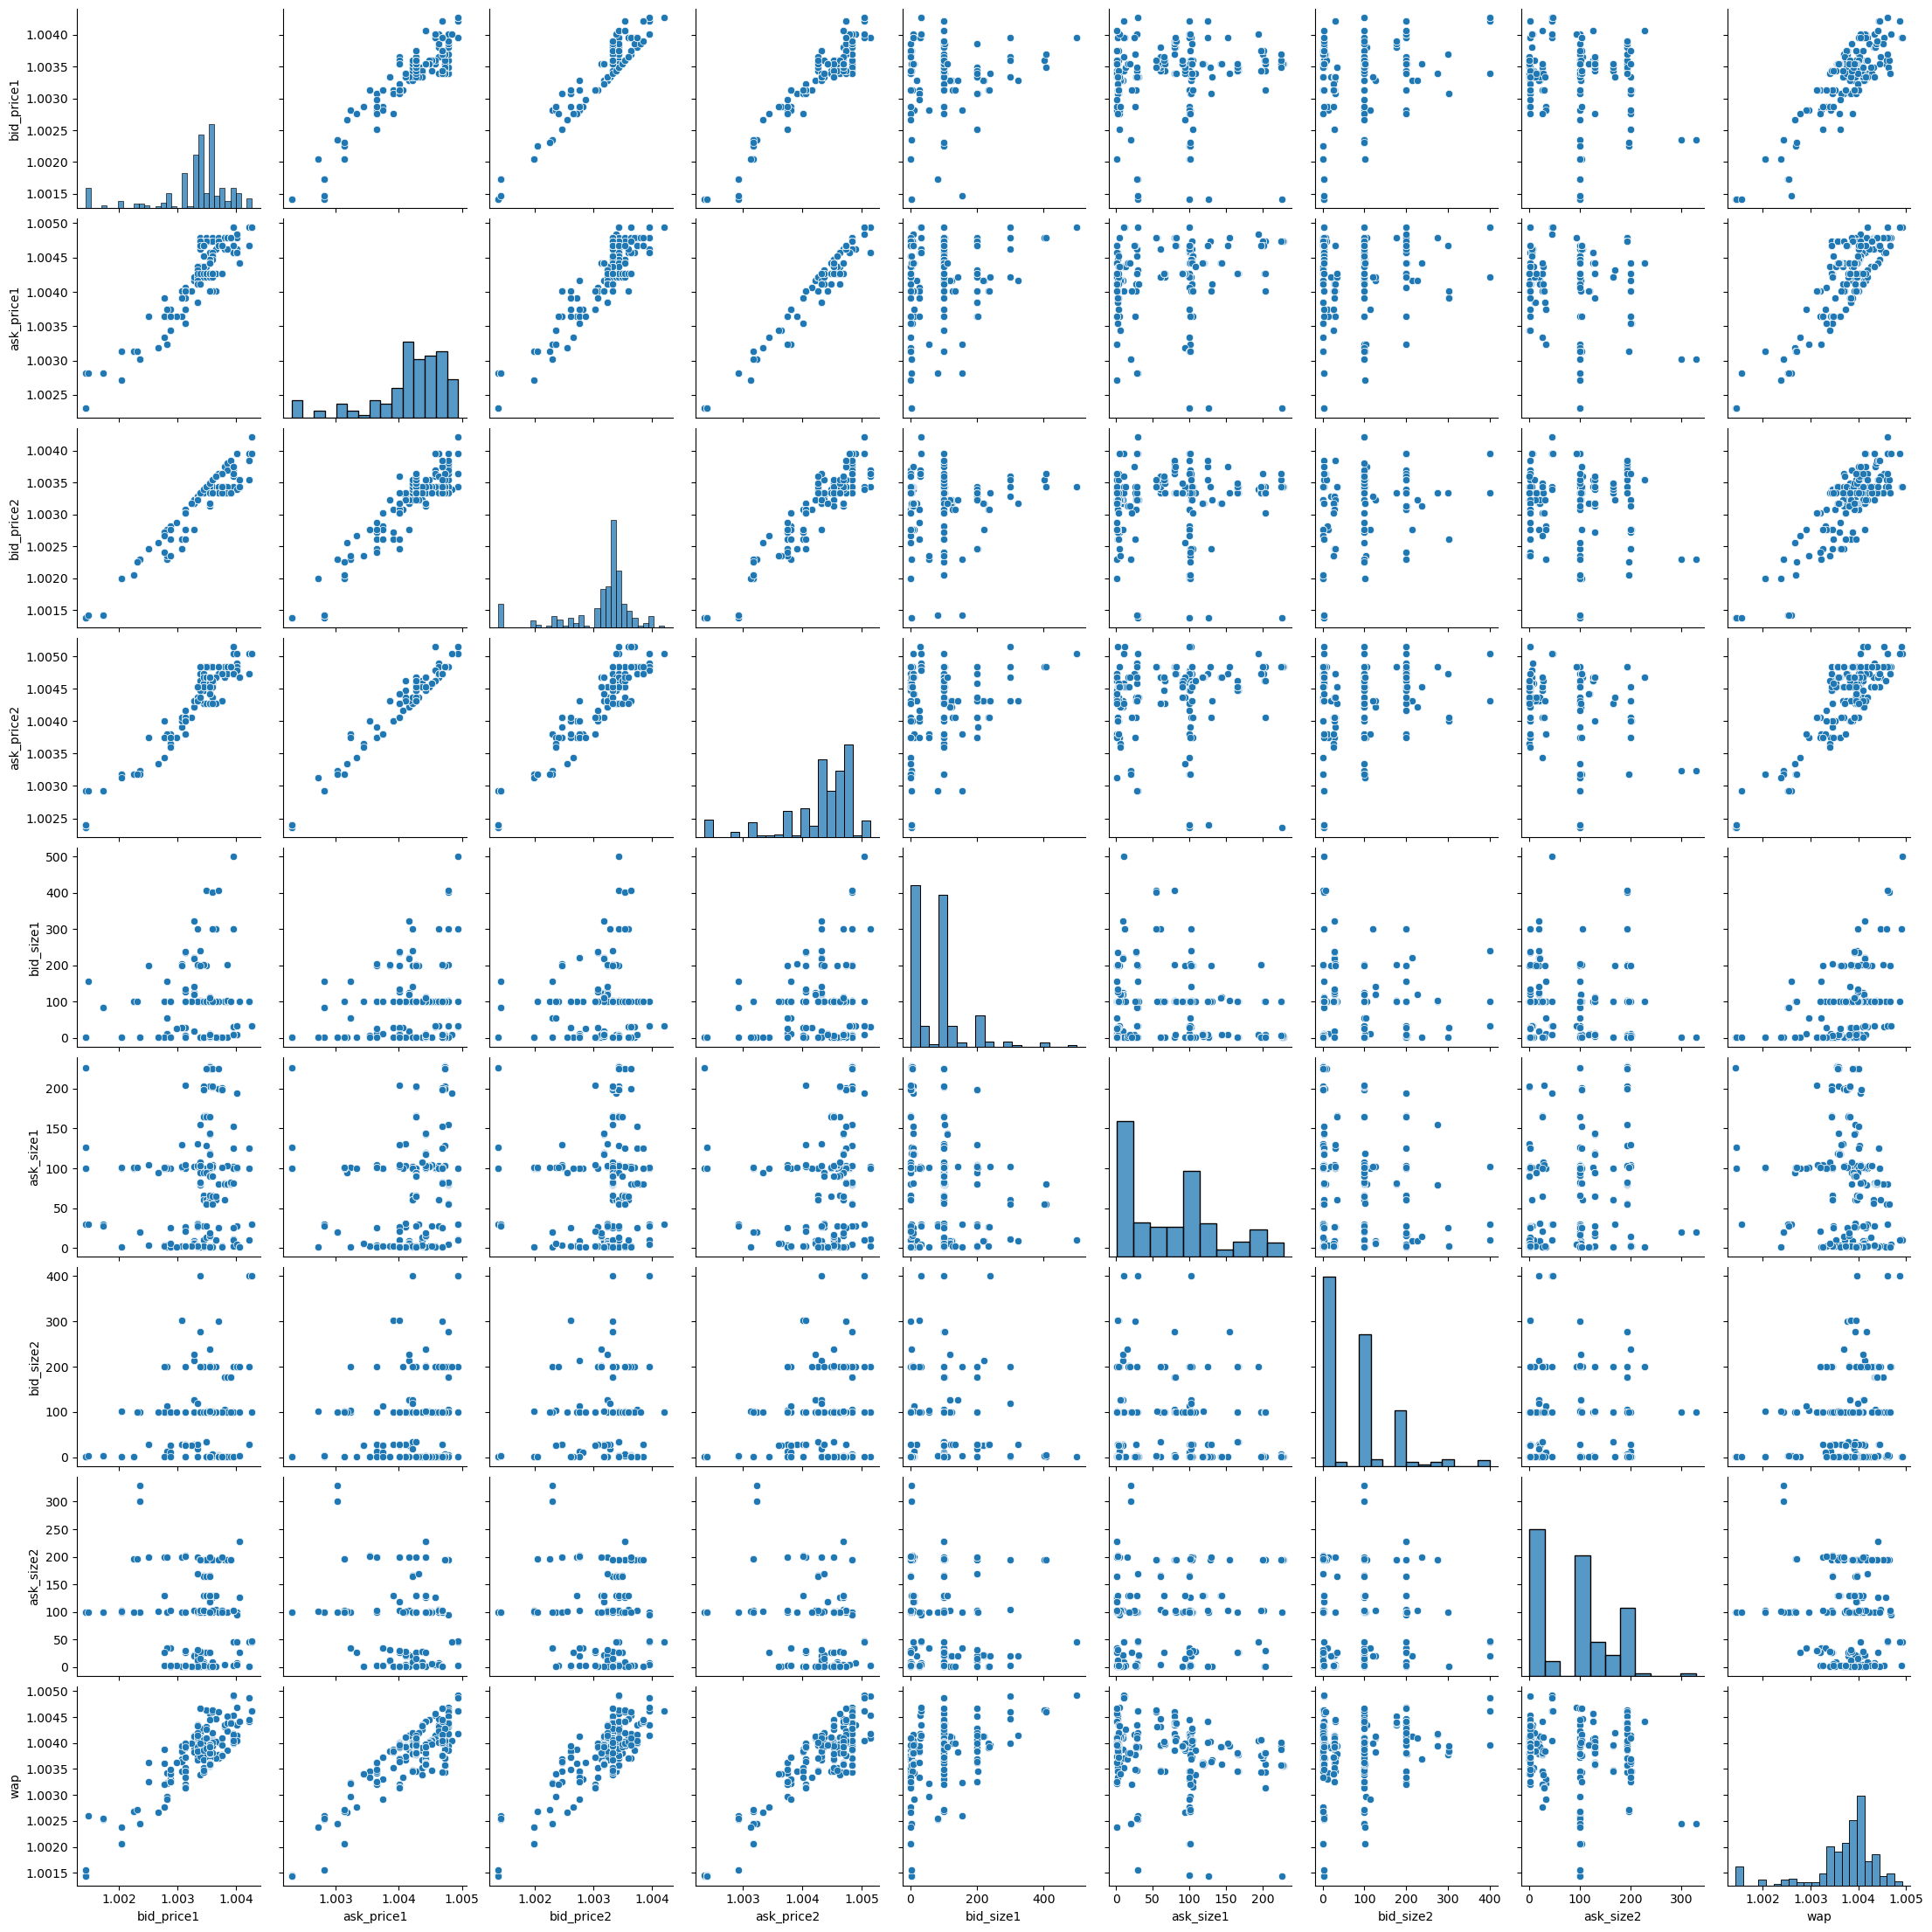

In [45]:
test = k[a].astype(float)

sns.pairplot(test)
test.corr()

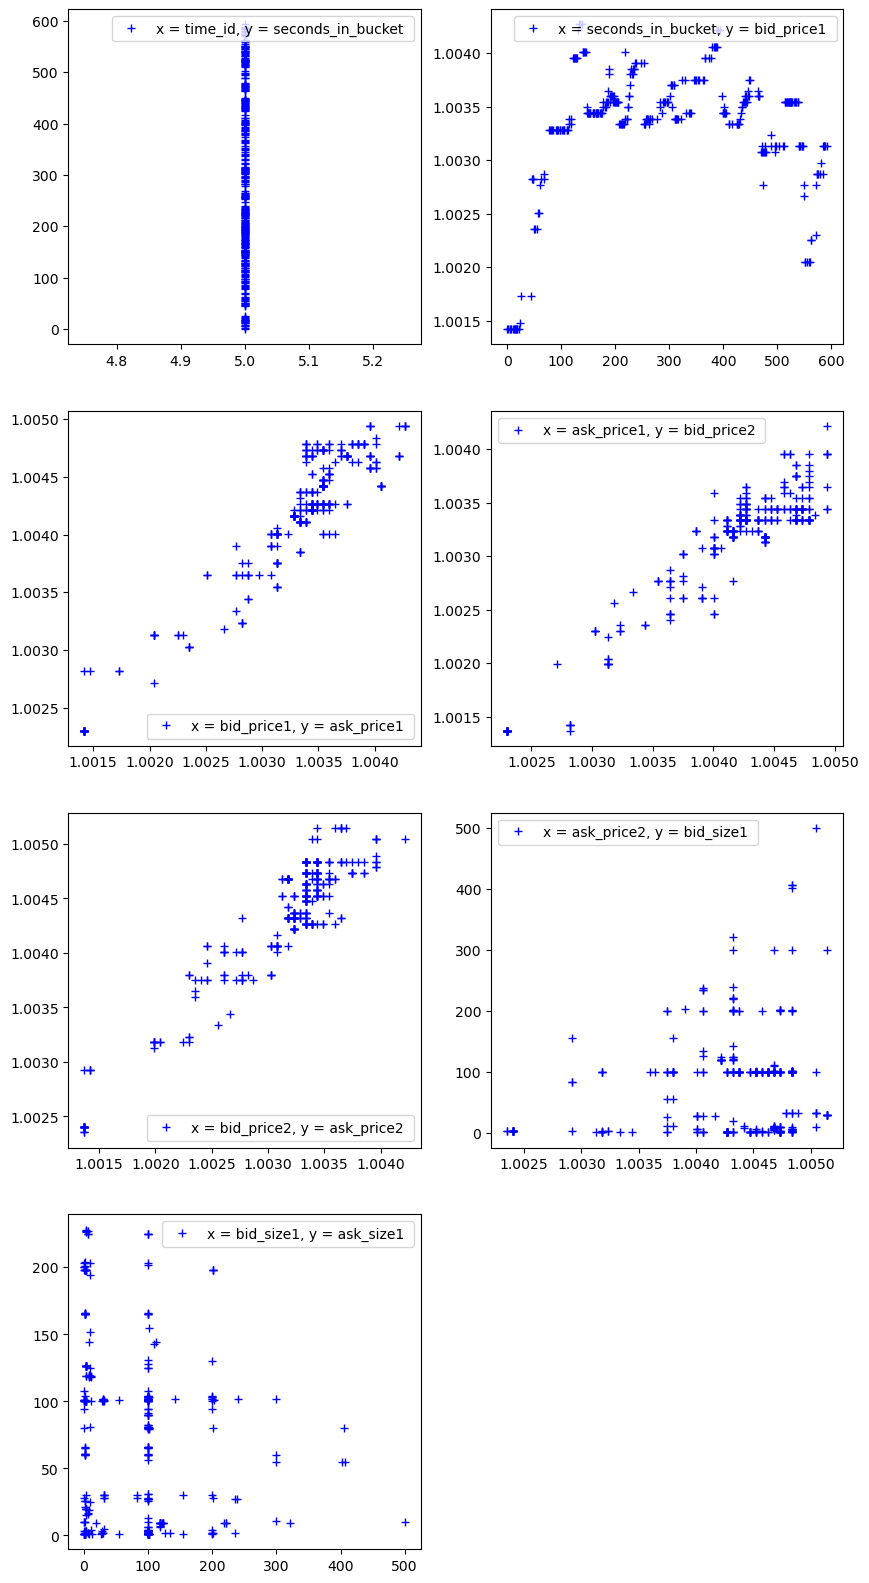

In [21]:
import matplotlib.pyplot as plt

yplot_num = 4
xplot_num = 2

plt.figure(figsize=(xplot_num * 5, yplot_num * 5))
for idx, x in enumerate(k.columns[2:10]):
    if idx == len(k.columns[2:10])-1:
        break
    else:
        plt.subplot(yplot_num, xplot_num, idx+1)
        plt.plot(k[k.columns[idx]], k[k.columns[idx+1]], 'b+', label=f'x = {k.columns[idx]}, y = {k.columns[idx+1]} ')
        plt.legend()

In [ ]:
train_df

In [ ]:
k.time_id

0      5
1      5
2      5
3      5
4      5
      ..
297    5
298    5
299    5
300    5
301    5
Name: time_id, Length: 302, dtype: int16

In [ ]:
k[k.seconds_in_bucket >= 520]

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
260,5,520,1.003543,1.004422,1.003181,1.004680,8,120,2,129,0
261,5,521,1.003543,1.004008,1.003181,1.004422,12,1,2,119,0
262,5,522,1.003543,1.004008,1.003181,1.004422,8,1,2,118,0
263,5,523,1.003543,1.004422,1.003181,1.004680,11,118,2,129,0
264,5,524,1.003543,1.004422,1.003181,1.004680,11,119,2,129,0
265,5,525,1.003543,1.004422,1.003181,1.004680,4,119,2,129,0
266,5,526,1.003543,1.004422,1.003181,1.004680,4,119,102,129,0
267,5,528,1.003543,1.004422,1.003181,1.004680,8,119,102,129,0
268,5,531,1.003543,1.004422,1.003181,1.004680,10,119,102,129,0
269,5,532,1.003543,1.004422,1.003181,1.004680,10,119,2,129,0


In [ ]:
pd.read_parquet('./Data/optiver-realized-volatility-prediction/trade_train.parquet')

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0
...,...,...,...,...,...,...
38382736,32767,570,0.999932,100,1,99
38382737,32767,575,0.999932,100,1,99
38382738,32767,579,0.999797,300,3,99
38382739,32767,584,0.999854,172,2,99


In [ ]:
pd.read_parquet('./Data/optiver-realized-volatility-prediction/book_train.parquet')

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
...,...,...,...,...,...,...,...,...,...,...,...
167253284,32767,589,0.999662,0.999797,0.999527,0.999932,400,600,400,528,99
167253285,32767,590,0.999662,0.999797,0.999527,0.999932,400,500,400,528,99
167253286,32767,592,0.999527,0.999797,0.999391,0.999932,900,600,600,528,99
167253287,32767,596,0.999527,0.999797,0.999391,0.999932,900,700,600,628,99


In [ ]:
pd.read_csv('./Data/optiver-realized-volatility-prediction/test.csv')

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34
